In [1]:
# https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial8/Deep_Energy_Models.html

In [2]:
import os, sys
import torch
import importlib
import pdb
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML

import setuptools
import torch
import torch.nn as nn
import pytorch_lightning as pl

# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

sys.path.append('../')
sys.path.append('../cpflow')  # Shouldn't be needed 

from src.models import DeepEnergyModel


/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


In [3]:
CHECKPOINT_PATH = "../models/EBM/"
DATASET_PATH = '../data/'


In [4]:

import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial8/"
# Files to download
pretrained_files = ["MNIST.ckpt", "tensorboards/events.out.tfevents.MNIST"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print("Downloading %s..." % file_url)
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)


In [5]:
pretrained_filename = os.path.join(CHECKPOINT_PATH,"MNIST.ckpt")
if os.path.isfile(pretrained_filename):
    print("Found pretrained model, loading...")
    model = DeepEnergyModel.load_from_checkpoint(pretrained_filename)
    
    
model.eval()
model.cnn.eval()
assert not model.cnn.training

Found pretrained model, loading...


In [6]:
# Transformations applied on each image => make them a tensor and normalize between -1 and 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_set = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = DataLoader(train_set, batch_size=128, shuffle=True,  drop_last=True,  num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=256, shuffle=False, drop_last=False, num_workers=4)

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


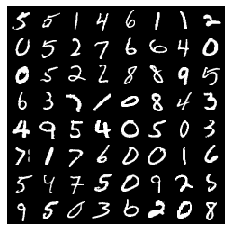

In [7]:
import matplotlib.pyplot as plt
from src.utils import show
from torchvision.utils import make_grid


X_real, Y = iter(train_loader).next()

grid = make_grid(X_real[:64], nrow=8, normalize=True, range=(-1,1))
show(grid)

In [8]:
model.sampler.img_shape

(1, 28, 28)

tensor(-17.8944, grad_fn=<MeanBackward0>)


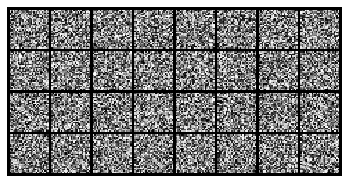

tensor(-0.0249, grad_fn=<MeanBackward0>)


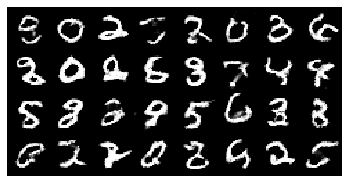

In [9]:
import random
import numpy as np
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


n = 32

X_noise = torch.rand((n,) + (1, 28, 28)) * 2 - 1
grid = make_grid(X_noise[:64], nrow=8, normalize=True, range=(-1,1))
show(grid)
print(model.cnn(X_noise.detach()).mean())
plt.show()

X_fake = model.sampler.generate_samples(model, X_noise.clone(), steps=200, step_size=10)
grid = make_grid(X_fake[:64], nrow=8, normalize=True, range=(-1,1))
print(model.cnn(X_fake.detach()).mean())
show(grid)


In [25]:
import importlib
import src.flow
import src.utils
import src.callbacks
importlib.reload(src.flow)
importlib.reload(src.utils)
importlib.reload(src.callbacks)

from src.utils import KDE_plot_2d
from src.functionals import PotentialFunctional, FokkerPlanckFunctional
from src.flow import GradFlow
from src.callbacks import EmbeddingCallback


# X = ....
F = PotentialFunctional(lambda x: torch.exp(-model.cnn(x)))
#F = PotentialFunctional(lambda x: -model.cnn(x))
F = PotentialFunctional(lambda x: torch.norm(x))


#F = FokkerPlanckFunctional(lambda x: -model.cnn(x))

fname = 'V_flow'
X_0 = X_noise.detach().clone()

save_path = None#os.path.join('../out/toy_pde/', fname)

cb = EmbeddingCallback(density_cmap='jet')


gf = GradFlow(X_0, F=F, τ=1e-3, lr = 1e-3, opt_iters=20, callbacks=cb,
              inner_print_freq=20, save_path = save_path)# xrng=(0,1), yrng=(0,1))

tsnecuda not found - will use (slower) cpu implementation


In [26]:
XT = gf.flow(steps=20)

Perplexity value 50 is too high. Using perplexity 10.33 instead


--------------------------------------------------------------------------------
TSNE(affinities=None, callbacks=None, callbacks_every_iters=50, dof=1,
   early_exaggeration=12, early_exaggeration_iter=250, exaggeration=None,
   final_momentum=0.8, initial_momentum=0.5, initialization='pca',
   ints_in_interval=1, learning_rate='auto', max_grad_norm=None,
   max_step_norm=5, metric='euclidean', metric_params=None,
   min_num_intervals=50, n_components=2, n_interpolation_points=3,
   n_iter=500, n_jobs=8, negative_gradient_method='fft', neighbors='auto',
   perplexity=50, random_state=None, theta=0.5, verbose=2)
--------------------------------------------------------------------------------
===> Finding 31 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.11 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exagg

It     W(ρ,ρ_t) F(ρ)=𝒱(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
   0       0.16     150.49     2.86     5.98   3.33e-01
  20       0.04      58.27     2.86     1.87   2.06e-02
===> Finding 15 nearest neighbors in existing embedding using exact search...
   --> Time elapsed: 0.11 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 160.3814, 50 iterations in 0.0164 sec
Iteration  100, KL divergence 154.8844, 50 iterations in 0.0184 sec
Iteration  150, KL divergence 154.5999, 50 iterations in 0.0143 sec
Iteration  200, KL divergence 154.5999, 50 iterations in 0.0122 sec
Iteration  250, KL divergence 154.5999, 50 iterations in 0.0112 sec
   --> Time elapsed: 0.07 seconds
It     W(ρ,ρ_t) F(ρ)=𝒱(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
   0       0.41     135.02     1

  20       0.02      38.61     1.40     5.16   3.27e-02
===> Finding 15 nearest neighbors in existing embedding using exact search...
   --> Time elapsed: 0.11 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 163.5933, 50 iterations in 0.0130 sec
Iteration  100, KL divergence 156.1644, 50 iterations in 0.0092 sec
Iteration  150, KL divergence 155.6134, 50 iterations in 0.0086 sec
Iteration  200, KL divergence 155.6135, 50 iterations in 0.0092 sec
Iteration  250, KL divergence 155.6135, 50 iterations in 0.0103 sec
   --> Time elapsed: 0.05 seconds
It     W(ρ,ρ_t) F(ρ)=𝒱(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
   0       0.98     185.68     4.15    31.18   9.66e-01
  20       0.05      41.93     4.15     2.01   2.98e-02
===> Finding 15 nearest neighb

  20       0.06      62.78     3.43    10.05   6.18e-03
===> Finding 15 nearest neighbors in existing embedding using exact search...
   --> Time elapsed: 0.10 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 164.2500, 50 iterations in 0.0134 sec
Iteration  100, KL divergence 156.5310, 50 iterations in 0.0101 sec
Iteration  150, KL divergence 156.0542, 50 iterations in 0.0093 sec
Iteration  200, KL divergence 156.0543, 50 iterations in 0.0089 sec
Iteration  250, KL divergence 156.0543, 50 iterations in 0.0112 sec
   --> Time elapsed: 0.05 seconds
It     W(ρ,ρ_t) F(ρ)=𝒱(ρ)     ‖X‖   ‖T(X)‖    ‖ΔT(X)‖
   0       0.18      47.16     9.88     2.08   4.11e-01
  20       0.04      32.20     9.88     4.56   9.44e-03
===> Finding 15 nearest neighb

In [27]:
from IPython.display import HTML

HTML(cb.animation.to_html5_video())